In [2]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sc

from scipy import linalg
from scipy import stats
from scipy.special import legendre

import statsmodels.api as sm
from patsy import dmatrices

import matplotlib.pyplot as plt
import seaborn as sns

import attrs
import utils
from attrs import start_dist_list, end_dist_list, start_args, end_args, moments

In [3]:
# Quantiles
qs_coarse = np.arange(0.05, 1, 0.05)
qs = np.arange(0.001, 1, 0.001)
qs_full = np.arange(0, 1.001, 0.001)

/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2560: RuntimeWarning: invalid value encountered in subtract
  return sc.xlogy(a-1.0, x) - x - sc.gammaln(a)
/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2560: RuntimeWarning: invalid value encountered in subtract
  return sc.xlogy(a-1.0, x) - x - sc.gammaln(a)


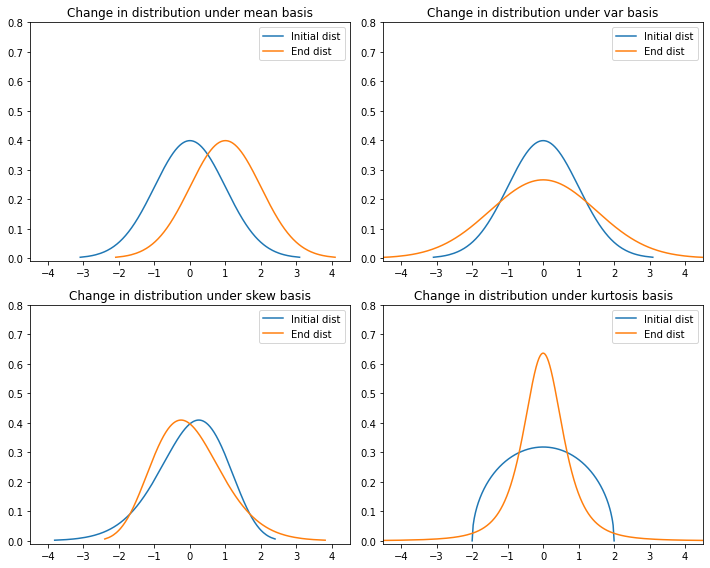

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
axes = axes.ravel()

for i in range(4):

    start_dist = start_dist_list[i]
    start_quantiles = start_dist.ppf(qs_full, **start_args[i])

    end_dist = end_dist_list[i]
    end_quantiles = end_dist.ppf(qs_full, **end_args[i])

    # Plot pdfs
    axes[i].plot(
        start_quantiles, start_dist.pdf(start_quantiles, **start_args[i]),
        label='Initial dist', color='tab:blue'
    )
    axes[i].plot(
        end_quantiles, end_dist.pdf(end_quantiles, **end_args[i]),
        label='End dist', color='tab:orange'
    )

    # ## Plot rugs (with coarser grid)
    # ax.plot(
    #     start_dist.ppf(qs_coarse, **start_args[i]), np.zeros_like(qs_coarse),
    #     ls='', marker='|', color='tab:blue', alpha=0.5, ms=10,
    #     markeredgewidth=3
    # )
    # ax.plot(
    #     end_dist.ppf(qs_coarse, **end_args[i]), np.zeros_like(qs_coarse),
    #     ls='', marker='|', color='tab:red', alpha=0.5, ms=10,
    #     markeredgewidth=3
    # )
    axes[i].set_ylim(-0.01, 0.8)
    axes[i].set_xlim(-4.5, 4.5)


    axes[i].set_title('Change in distribution under {} basis'.format(moments[i]))
    axes[i].legend(loc='upper right')
    # ax.grid()

fig.tight_layout()
fig.savefig(os.path.join(attrs.VISUALIZATION_PATH, 'pearson_basis_distributions.png'))

## Issue with moment basis functions: non-orthogonality

In [5]:
utils.moment_basis(qs_coarse)

# Create dataframe
df = pd.DataFrame(
    utils.moment_basis(qs_coarse).transpose(),
    columns=['mean', 'variance', 'skew', 'kurtosis'],
    index=qs_coarse,
)
df.head()

,mean,variance,skew,kurtosis
0.05,1.0,-0.822427,0.283272,0.252052
0.10,1.0,-0.640776,0.106917,0.428546
0.15,1.0,-0.518217,0.012561,0.448715
0.20,1.0,-0.420811,-0.048238,0.418802
0.25,1.0,-0.337245,-0.090364,0.366335


In [6]:
corr_matrix = df.corr()
html = (
    corr_matrix.style
    .background_gradient(cmap='RdBu_r', vmin=-1, vmax=1)
    .set_precision(2)
)
html

,mean,variance,skew,kurtosis
mean,1.00,-0.23,0.15,0.35
variance,-0.23,1.00,0.00,-0.90
skew,0.15,0.00,1.00,-0.00
kurtosis,0.35,-0.90,-0.00,1.00


## Plot of changes in distribution for legendre basis
We take the scaled legendre basis, and apply the changes in quantiles to the standard normal distribution to see what changes in the shape of the distribution they incur.

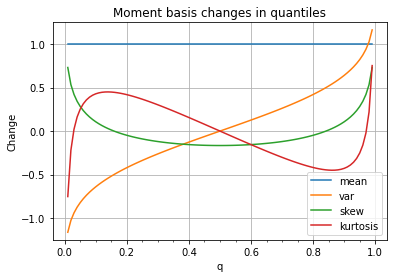

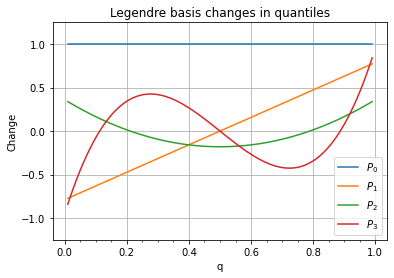

In [10]:
qs = np.arange(0.01, 1, 0.01)
moment_basis = utils.moment_basis(qs)
leg_basis = np.array([
    utils.legendre_scaling_coefficients(qs_coarse)[i]*utils.legendre_basis(qs, scaled=False)[i] for i in range(4)
])

xtickmajor = np.arange(0, 1.2, 0.2)
xtickminor = np.arange(0, 1.05, 0.05)

fig, ax = plt.subplots()
for i in range(4):
    ax.plot(qs, moment_basis[i], label=attrs.moments[i])

ax.set(
    title='Moment basis changes in quantiles',
    xlabel='q',
    ylabel='Change',
    ylim=(-1.25, 1.25)
)
ax.set_xticks(xtickmajor)
ax.set_xticks(xtickminor, minor=True)

ax.grid();
ax.legend(loc='lower right')
fig.savefig(
    os.path.join(attrs.VISUALIZATION_PATH, 'moment_basis_functions.png')
)

fig, ax = plt.subplots()

for i in range(4):
    ax.plot(qs, leg_basis[i], label=r'$P_{}$'.format(i))

ax.set(
    title='Legendre basis changes in quantiles',
    xlabel='q',
    ylabel='Change',
    ylim=(-1.25, 1.25)
)

ax.set_xticks(xtickmajor)
ax.set_xticks(xtickminor, minor=True)

ax.grid();
ax.legend(loc='lower right')
fig.savefig(
    os.path.join(attrs.VISUALIZATION_PATH, 'scaled_legendre_basis_functions.png')
)

In [13]:
# Scaling coefficients for different refined quantiles
print(utils.legendre_scaling_coefficients(np.arange(0.05, 1, 0.05)))
print(utils.legendre_scaling_coefficients(np.arange(0.01, 1, 0.01)))
print(utils.legendre_scaling_coefficients(np.arange(0.001, 1, 0.001)))

[1.         0.78855954 0.36046589 0.95277938]
[1.         0.84008161 0.44754356 0.88823381]
[1.         0.8616865  0.50603048 1.09834845]


The scalings for the legendre basis depend on the number of quantiles that are used. In general, more refined qs will result in higher representation of qs near 0 and 1, which diverge to infinity, so the of the moment basis functions increase for more refined qs. Therefore, we will stick with the scaling coefficients for the q-spacing of 0.05, but will use a more refined grid spacing of 0.001 to compute the changes in quantiles

In [14]:
# Quantiles for normal distribution, for legendre var basis
scales = utils.legendre_scaling_coefficients(np.arange(0.05, 1, 0.05))
scales
# utils.

array([1.        , 0.78855954, 0.36046589, 0.95277938])

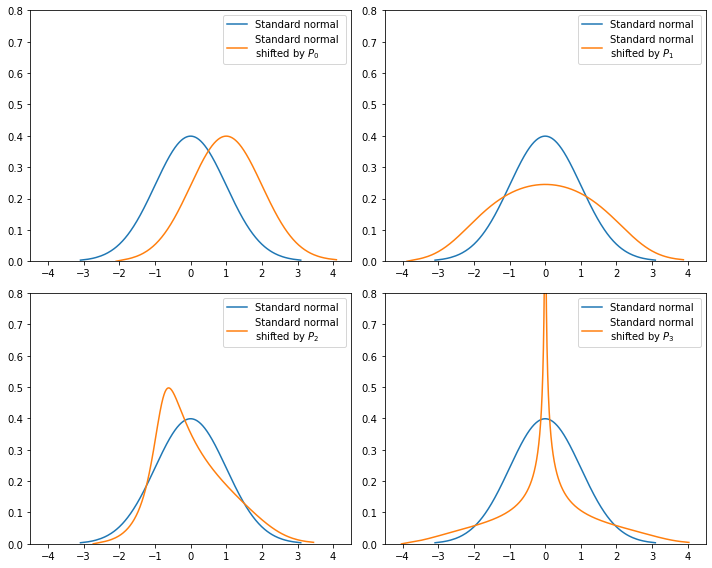

In [19]:
qs = np.arange(0.001, 1, 0.001)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
axes = axes.ravel()
for i in range(4):
    leg_quantile_changes = scales[i] * utils.legendre_basis(qs, scaled=False)[i]
    leg_ppf = np.sort(stats.norm.ppf(qs) + leg_quantile_changes)

    # First order finite difference of cdf
    pdf = 0.001/(leg_ppf - np.roll(leg_ppf, shift=1))

    axes[i].plot(stats.norm.ppf(qs), stats.norm.pdf(stats.norm.ppf(qs)), label='Standard normal')
    # ax.plot(leg_ppf, pdf, label='Standard normal with \nlegendre {} shift'.format(attrs.moments[i]))
    axes[i].plot(leg_ppf, pdf, label='Standard normal \nshifted by' + r' $P_{}$'.format(i))
    axes[i].legend(loc='upper right')
    axes[i].set(
        xlim=(-4.5,4.5),
        ylim=(0,0.8)
    )

fig.tight_layout()
fig.savefig(os.path.join(attrs.VISUALIZATION_PATH, 'legendre_basis_distributions.png'))

In [11]:
utils.moment_basis(qs)

# Create dataframe
df = pd.DataFrame(
    utils.legendre_basis(qs).transpose(),
    columns=['mean', 'variance', 'skew', 'kurtosis'],
    index=qs,
)
df.head()

,mean,variance,skew,kurtosis
0.001,1.0,-0.859963,0.502997,-1.085201
0.002,1.0,-0.858240,0.499970,-1.072120
0.003,1.0,-0.856516,0.496949,-1.059104
0.004,1.0,-0.854793,0.493934,-1.046154
0.005,1.0,-0.853070,0.490925,-1.033269


In [106]:
# Add jitter to means so they have nonzero std in computation of correlation (or get nans due to division by 0)
rng = np.random.default_rng(0)
df['mean'] = np.ones(999) + 1e-10*(rng.normal(999))

In [107]:
corr_matrix = df.corr()

html = (
    corr_matrix.style
    .background_gradient(cmap='RdBu_r')
    .set_precision(2)
)
html

,mean,variance,skew,kurtosis
mean,1.00,0.00,-0.00,0.00
variance,0.00,1.00,0.00,-0.00
skew,-0.00,0.00,1.00,0.00
kurtosis,0.00,-0.00,0.00,1.00
